In [1]:
import awkward as ak
import dask_awkward as dak
import numpy as np
import ROOT as rt

In [2]:
load_path = "/work/users/yun79/stage2_output/test/processed_events_signalMC.parquet"
processed_eventsSignalMC = ak.from_parquet(load_path)
name = "Canvas"
canvas = rt.TCanvas(name,name,800, 800) # giving a specific name for each canvas prevents segfault?
canvas.cd()

[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 20 out-of-range events
[#1] INFO:Fitting -- RooAbsPdf::fitTo(ggH Signal Model subCat 0_over_ggH Signal Model subCat 0_Int[ggH_dimuon_mass]) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- using CPU computation library compiled with -mavx2
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_ggH Signal Model subCat 0_over_ggH Signal Model subCat 0_Int[ggH_dimuon_mass]_SigMC_hist) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 2500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 75442.7597377711063
Edm   = 1.02291638251235938e-05
Nfcn  = 281
alpha1	  = 1.02567	 +/-  0.021592	(limited)
alpha2	  = 1.41499	 +/-  0.0324493	(limited)
n1	  = 4.1674	 +/-  0.276325	(limited)
n2	  = 5.93911	 +/-  0.5820

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       79130.89447 Edm =       27042.87881 NCalls =     21
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 75906.48266
  Edm           : 432.6738157
  Internal parameters:	[     -1.219013257     -1.219013257     -1.378904899     -1.240029952   -0.02564383614]	
  Internal gradient  :	[      16931.08974      3156.889288      4123.085471      437.4484233     -2608.210668]	
  Internal covariance matrix:
[[  2.9510072e-06              0              0              0              0]
 [              0  8.3102718e-06              0              0              0]
 [              0              0  1.8977596e-05              0              0]
 [              0              0              0  0.00014549743          

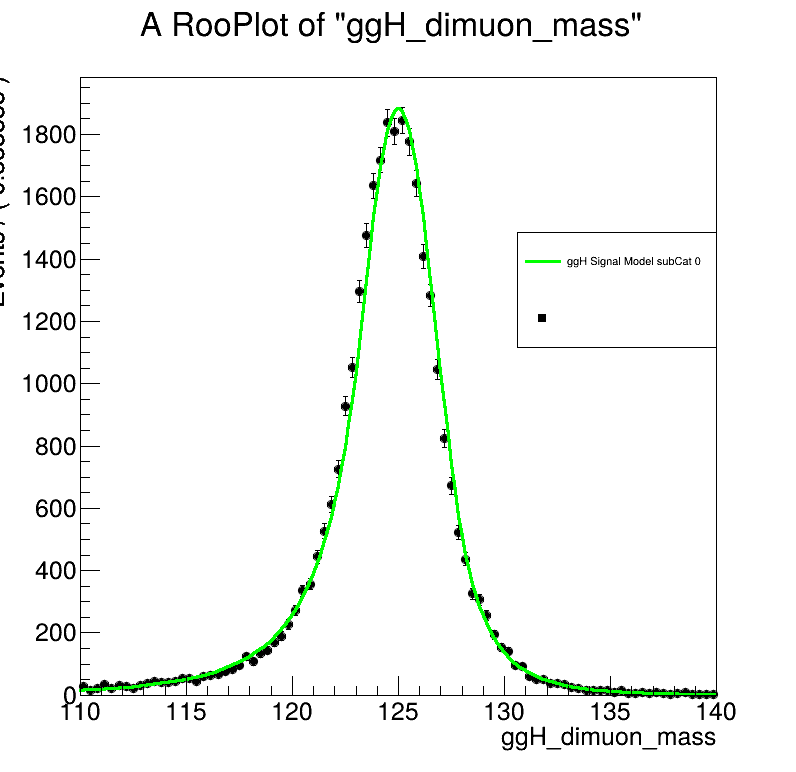

In [3]:
cat_ix = 0
subCat_filter = (processed_eventsSignalMC["subCategory_idx"] == cat_ix)
subCat_mass_arrSigMC = processed_eventsSignalMC.dimuon_mass[subCat_filter]
subCat_mass_arrSigMC  = ak.to_numpy(subCat_mass_arrSigMC) # convert to numpy for rt.RooDataSet

# the mass range and nbins are taken from Fig 6.15 of the long AN (page 57)
mass_name = "ggH_dimuon_mass"
massSigMC =  rt.RooRealVar(mass_name,mass_name,125,110,140) # h peak range
nbins = 90 # This could be wrong bc I counted by hand from the histogram
massSigMC.setBins(nbins)

roo_datasetSigMC = rt.RooDataSet.from_numpy({mass_name: subCat_mass_arrSigMC}, [massSigMC])
roo_histSigMC = rt.RooDataHist("SigMC_hist",f"binned version of SigMC of subcat {cat_ix}", rt.RooArgSet(massSigMC), roo_datasetSigMC)  # copies binning from mass variable
# make roofit signal model
mH = rt.RooRealVar("mH" , "mH", 125, 115,135)
mH.setConstant(True) #
sigma = rt.RooRealVar("sigma" , "sigma", 2, .1, 4.0)
alpha1 = rt.RooRealVar("alpha1" , "alpha1", 2, 0.01, 65)
n1 = rt.RooRealVar("n1" , "n1", 10, 0.01, 100)
alpha2 = rt.RooRealVar("alpha2" , "alpha2", 2.0, 0.01, 65)
n2 = rt.RooRealVar("n2" , "n2", 25, 0.01, 100)
# n1.setConstant(True) # freeze for stability
# n2.setConstant(True) # freeze for stability
dcb_name = f"ggH Signal Model subCat {cat_ix}"
sig_model = rt.RooCrystalBall(dcb_name,dcb_name,massSigMC, mH, sigma, alpha1, n1, alpha2, n2)

# fit signal model
_ = sig_model.fitTo(roo_histSigMC,  EvalBackend="cpu", Save=True, )
fit_result = sig_model.fitTo(roo_histSigMC,  EvalBackend="cpu", Save=True, )

# clear canvas to plot the signal model
canvas.Clear()
frame = massSigMC.frame()
roo_datasetSigMC.plotOn(frame, DataError="SumW2", Name=roo_datasetSigMC.GetName())
sig_model.plotOn(frame, Name=sig_model.GetName(), LineColor=rt.kGreen)
frame.Draw()


# legend
legend = rt.TLegend(0.65,0.55,0.9,0.7)
name=sig_model.GetName()
legend.AddEntry(name,name, "L")

name=roo_datasetSigMC.GetName()
legend.AddEntry(name,name, "P")
legend.Draw()

canvas.Update()
canvas.Draw()

canvas.SaveAs(f"./quick_plots/stage3_plot_SigMC_ggH{cat_ix}.pdf")